In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper, OpenURL, TapTool, ResetTool
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save, output_notebook
from bokeh.io import curdoc

In [ ]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
               'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [ ]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [ ]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

In [ ]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

In [ ]:
link_list

In [ ]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [ ]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [ ]:
df_late_battles

In [ ]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

In [ ]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [ ]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [ ]:
df_late_battles.head()

In [ ]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [ ]:
battle_list = []
link_list = []

In [ ]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [ ]:
for page in table_pages:
    print page
    early_battles(page)

In [ ]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [ ]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [ ]:
len(df_battles)

In [ ]:
len(df_late_battles)

In [ ]:
df_battles.head()

In [ ]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [ ]:
len(df_url)

In [ ]:
len(df_url.drop_duplicates())

In [ ]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [ ]:
if ul is not None:
    print 'works'

In [ ]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:

        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

In [ ]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

In [ ]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [ ]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [ ]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [ ]:
len(df_comm)

In [ ]:
len(df_comm)

In [ ]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [ ]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df_comm = df_comm.drop_duplicates()

In [ ]:
df_comm.head()

In [ ]:
len(df_comm)

In [ ]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

In [ ]:
len(df_comm.drop_duplicates())

In [ ]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [ ]:
df_comm.to_csv('battles_deduped.csv')

In [ ]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

In [ ]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

In [ ]:
df_results = pd.read_csv('result_column.csv')

In [ ]:
df_results[df_results.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm.head()

In [ ]:
df_results.head()

In [ ]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [ ]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [ ]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [ ]:
df_more_results.head()

In [ ]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [ ]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [ ]:
df_vl

In [ ]:
df_vl = df_vl.sort('VorD')

In [ ]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl[df_vl.belligerent == 'Saracens']

In [ ]:
df_vl.to_csv('additional_results.csv')

In [ ]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

In [ ]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [ ]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [ ]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [ ]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [ ]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [ ]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [ ]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [ ]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

In [ ]:
df_test = df_some_strength.iloc[:,9:]

In [ ]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [ ]:
len(df_str_two)

In [ ]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [ ]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

In [ ]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength

In [ ]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

In [ ]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

In [ ]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

In [ ]:
len(df_some_strength)

In [ ]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

In [ ]:
df_some_strength

In [ ]:
df_fill_two

In [ ]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

In [ ]:
len(df_battles)

In [ ]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

In [ ]:
df_char.to_excel('special_character_fix.xlsx')

In [ ]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

In [ ]:
df_all_strength.to_excel('all_strength_probably.xlsx')

In [ ]:
df_battles[df_battles.Battle.str.contains('dlingen')]

In [ ]:
df_char.Battle

In [5]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [6]:
df_strength_all = df_strength_all.drop_duplicates()

In [7]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [8]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [9]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [10]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [11]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [12]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [13]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [14]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [15]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [16]:
df_model[df_model.Battle == 'Siege of Kojinyama']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,Infantry_y,Cavalry_y,Artillery_y,Ships_y,Airforce_y,Special_y
2346,Siege of Kojinyama,L,V,200.0,NaN,NaN,NaN,NaN,NaN,R,2000.0,NaN,NaN,NaN,NaN,NaN


In [17]:
df_model[2346, 'Infantry_x'] = 2000

In [18]:
df_model.VorD.value_counts()

V    1524
D     775
I     173
L       1
v       1
Name: VorD, dtype: int64

In [19]:
(1524 - 775) / 2

374.5

In [20]:
df_v = df_model[df_model.VorD == 'V']

In [21]:
v_list = list(df_v.index)

In [22]:
ran_list = random.sample(v_list, 374)

In [23]:
df_switch = df_model.iloc[ran_list]

In [24]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [25]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [26]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [27]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [28]:
df_switch.VorD = 'D'

In [29]:
df_switch.VorD.value_counts()

D    374
Name: VorD, dtype: int64

In [30]:
df_model = df_model.drop(ran_list)

In [31]:
df_model = pd.concat([df_model, df_switch])

In [32]:
df_model.VorD.value_counts()

V    1150
D    1149
I     173
L       1
v       1
Name: VorD, dtype: int64

In [33]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [34]:
df_model.loc[2363, 'Infantry_x'] = 500

In [35]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [36]:
df_model = df_model.fillna(0)

In [37]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [38]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [39]:
df_diff = df_diff[df_diff.VorD != 'I']

In [40]:
df_model[df_model.Battle == 'Siege of Noda']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Ships_y,Airforce_y,Special_y,"(2346, Infantry_x)",infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
2363,Siege of Noda,L,V,500.0,0.0,0.0,0.0,0.0,0.0,R,...,0.0,0.0,0.0,2000,0.818182,NaN,NaN,NaN,NaN,NaN


In [41]:
df_diff.sort_values('infantry_diff', ascending = False)

,VorD,Battle,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
934,D,Battle_of_Brices_Crossroads,1.000000,-0.029412,1.000000,NaN,NaN,NaN
327,D,Battle of Ikh Bayan,1.000000,-1.000000,NaN,NaN,NaN,NaN
152,D,Battle of Callinicum,1.000000,-0.600000,NaN,NaN,NaN,NaN
164,D,Battle of Carrhae,1.000000,-0.428571,NaN,NaN,NaN,NaN
578,D,Battle of Salsu,1.000000,-1.000000,NaN,NaN,NaN,NaN
476,V,Battle of NÄ›meckÃ½ Brod,1.000000,-1.000000,NaN,NaN,NaN,NaN
1639,D,Battle_of_Palo_Duro_Canyon,1.000000,-1.000000,NaN,NaN,NaN,NaN
644,V,Battle of the Arius,1.000000,-1.000000,NaN,NaN,NaN,NaN
1053,D,Battle_of_Copenhagen_(1801),1.000000,NaN,NaN,0.104478,NaN,NaN
1933,D,Battle_of_the_Mississinewa,1.000000,-1.000000,NaN,NaN,NaN,NaN


In [42]:
df_diff = df_diff.drop(174)

In [43]:
df_diff = df_diff.fillna(0)

In [44]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [45]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [46]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [47]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [48]:
df_y.VorD = df_y.VorD.astype('float')

In [49]:
df_x = df_x.iloc[:, :-1]

In [50]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
lr.score(df_x, df_y)

0.53997975708502022

In [52]:
pd.Series(df_x.columns)

0    infantry_diff
1     cavalry_diff
2       ships_diff
3    airforce_diff
dtype: object

In [53]:
lr.coef_[0]

array([ 0.40991476,  0.09851692,  0.57281067,  0.11998676])

In [54]:
pd.concat([pd.Series(lr.coef_[0]), pd.Series(df_x.columns)], axis = 1)

,0,1
0,0.409915,infantry_diff
1,0.098517,cavalry_diff
2,0.572811,ships_diff
3,0.119987,airforce_diff


In [55]:
df_test = pd.concat([df_y.reset_index(drop = True), pd.Series(lr.predict(df_x))], axis = 1)

In [56]:
df_test.head()

,VorD,0
0,1.0,1.0
1,1.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [57]:
len(df_test)

1976

In [58]:
count = 0
for i, row in df_test.iterrows():
    if row['VorD'] == row[0]:
        count = count + 1

In [59]:
scores = cross_val_score(lr, df_x, df_y.VorD, cv = 10)

In [60]:
scores.mean()

0.538124414308635

In [61]:
pd.concat([pd.DataFrame(lr.predict_proba(df_x)), df_x.reset_index(drop = True)] ,axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.496879,0.503121,-0.688334,0.000000,0.500000,0.0
1,0.463883,0.536117,0.332955,0.000000,0.000000,0.0
2,0.417633,0.582367,0.791045,0.000000,0.000000,0.0
3,0.494380,0.505620,0.034749,0.000000,0.000000,0.0
4,0.541535,0.458465,-0.666667,1.000000,0.000000,0.0
5,0.499621,0.500379,-0.016393,0.000000,0.000000,0.0
6,0.516041,0.483959,-0.073171,0.000000,-0.074074,0.0
7,0.510098,0.489902,-0.118644,0.000000,0.000000,0.0
8,0.538236,0.461764,-0.393939,0.000000,0.000000,0.0
9,0.446902,0.553098,0.500000,0.000000,0.000000,0.0


In [62]:
lr.coef_

array([[ 0.40991476,  0.09851692,  0.57281067,  0.11998676]])

In [63]:
df_test = pd.DataFrame({'infantry_diff':.99,
                       'cavalry_diff':.99,
                       'artillery_diff':.99,
                       'ships_diff':.99,
                       'airforce_diff:':.99}, index = [0])

In [64]:
df_test

,airforce_diff:,artillery_diff,cavalry_diff,infantry_diff,ships_diff
0,0.99,0.99,0.99,0.99,0.99


In [65]:
lr.predict_proba(df_test)

ValueError: X has 5 features per sample; expecting 4

In [66]:
df_model.VorD.value_counts()

V    991
D    974
I    128
0     10
L      1
v      1
Name: VorD, dtype: int64

In [67]:
1524 + 775

2299

In [68]:
2300 /2 - 775

375.0

In [69]:
rf = RandomForestClassifier()
rf.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
rf.score(df_x, df_y)

0.82591093117408909

In [71]:
scores = cross_val_score(rf, df_x, df_y.VorD, cv = 5)

In [72]:
scores

array([ 0.48989899,  0.48484848,  0.56455696,  0.46835443,  0.49238579])

In [73]:
rf.feature_importances_

array([ 0.77446462,  0.09141152,  0.10339202,  0.03073184])

In [74]:
pd.concat([pd.DataFrame(rf.predict_proba(df_x)), df_x.reset_index(drop = True)], axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.200000,0.800000,-0.688334,0.000000,0.500000,0.0
1,0.318658,0.681342,0.332955,0.000000,0.000000,0.0
2,0.900000,0.100000,0.791045,0.000000,0.000000,0.0
3,0.933333,0.066667,0.034749,0.000000,0.000000,0.0
4,0.283333,0.716667,-0.666667,1.000000,0.000000,0.0
5,0.266667,0.733333,-0.016393,0.000000,0.000000,0.0
6,0.150000,0.850000,-0.073171,0.000000,-0.074074,0.0
7,0.300000,0.700000,-0.118644,0.000000,0.000000,0.0
8,1.000000,0.000000,-0.393939,0.000000,0.000000,0.0
9,0.520545,0.479455,0.500000,0.000000,0.000000,0.0


In [75]:
df_strength_all[df_strength_all.Battle == 'Siege of Kojinyama']

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
9987,Siege of Kojinyama,1544,"Kojinyama fortress, Shinano Province",Takeda victory,Tozawa Yorichika,2000,2000,R,D,2000.0,NaN,NaN,NaN,NaN,NaN
9988,Siege of Kojinyama,1544,"Kojinyama fortress, Shinano Province",Takeda victory,Takeda Shingen,2000,2000,L,V,200.0,NaN,NaN,NaN,NaN,NaN


In [76]:
df_strength_all.loc[9806, 'Infantry'] = 2000

In [77]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [78]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [79]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [80]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [81]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [82]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [83]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [84]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [85]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [86]:
null_fill

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
4981,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Sweden,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
4982,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Magnus Stenbock,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
5100,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Ítalo Piaggi,690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
5101,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Wing commander (rank),690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
6236,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Habsburg Monarchy,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6237,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Count Leopold Joseph von Daun,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6307,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,David Farragut,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6308,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Navy,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6309,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Gordon Granger,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6310,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Army,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN


In [87]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [89]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [90]:
import re

In [91]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, str):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [92]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [93]:
df_strength_all['year'] = pd.Series()

In [94]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [95]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [96]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [97]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [98]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [99]:
df_run

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special,year
0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,3.0,2.0,NaN,NaN,NaN
1,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,7.0,2.0,NaN,NaN,NaN
2,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,L,V,923.0,NaN,NaN,6.0,NaN,NaN,NaN
3,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
4,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
5,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
6,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
7,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
8,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
9,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0


In [100]:
arras_1 = {'Battle':['Battle of Arras', 'Battle of Arras'], 
           'Date':['21 May 1940', '21 May 1940'],
           'Location':['Arras', 'Arras'], 
           'Result':['German victory', 'German victory'] ,
           'belligerent':['Erwin Rommel', 'Harold Franklyn'],
           'opp':['manual', 'manual'],
           'own':['manual', 'manual'], 
           'pos':['R', 'L'],
           'VorD':['V', 'D'],
           'Infantry':[7500.0, 2000.0],
           'Cavalry':[225.0, 74.0],
           'Artillery':[np.NaN, np.NaN],
           'Ships': [np.NaN, np.NaN],
           'Airforce': [np.NaN, np.NaN],
           'Special': [np.NaN, np.NaN],
           'year':[1940, 1940]}

In [101]:
df_run = pd.concat([df_run,pd.DataFrame(arras_1, index = [10515,10516])])

In [102]:
df_run

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
0,NaN,3.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
1,NaN,7.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
2,NaN,NaN,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,923.0,NaN,NaN,6.0,NaN,V,NaN,NaN,NaN,L,NaN
3,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
4,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
5,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
6,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
7,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
8,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
9,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0


In [103]:
len(arras_1)

16

In [104]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [105]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [106]:
df_lookup = pd.concat([df_lookup, pd.DataFrame(arras_1, index = [10515,10516])])

In [107]:
df_lookup[df_lookup['Battle'] == 'Six Day War']

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
10330,957.0,NaN,Six Day War,2504.0,"June 5–10, 1967 (6 days)",547000.0,Middle East,Decisive Israeli victory,NaN,NaN,D,Gamal Abdel Nasser,"50,000 troops\r\r\r\n214,000 reserves\r\r\r\n3...","Egypt: 240,000\r\r\r\nSyria, Jordan, and Iraq:...",R,1967.0
10342,300.0,NaN,Six Day War,800.0,"June 5–10, 1967 (6 days)",264000.0,Middle East,Decisive Israeli victory,NaN,NaN,V,Levi Eshkol,"Egypt: 240,000\r\r\r\nSyria, Jordan, and Iraq:...","50,000 troops\r\r\r\n214,000 reserves\r\r\r\n3...",L,1967.0


In [108]:
df_run.iloc[2346]

Airforce                                                     NaN
Artillery                                                    NaN
Battle                                          Battle of Pteria
Cavalry                                                      NaN
Date                                               Autumn 547 BC
Infantry                                                   95000
Location                                      Pteria, Cappadocia
Result         Tactical stalemate;\r\r\r\nStrategic Persian v...
Ships                                                        NaN
Special                                                      NaN
VorD                                                           I
belligerent                                          Dardanelles
opp                                                    20,000[2]
own                                                    95,000[1]
pos                                                            L
year                     

In [109]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    global df_battles
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():
        global row
        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)
        
        battle = row.loc[0,'Battle']

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
       
            
        
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp = opp.rename(columns = {'Infantry':'infantry_opp', 
                                    'Cavalry':'cavalry_opp', 
                                    'Artillery':'artillery_opp', 
                                    'Ships':'ships_opp', 
                                    'Airforce':'airforce_opp',
                                    'Special':'special_opp'})

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)

        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
#     if len(df_dbg) > 4:
#         war_list.append({'General':general,
#                      'WAR':war})
    war_list.append({'General': general,
                    'WAR': war,
                    'Battles': len(df_dbg)})
    print(war)
    

In [110]:
war_list = []
count = 0
for general in df_run.belligerent.unique():
    count += 1
    print(str(general) + ': ' + str(count) + '/' + str(len(df_run.belligerent.unique())))
    commander_war(general)

nan: 1/6620
0
David Ben-Gurion: 2/6620
0.970332000231
Yisrael Galili: 3/6620
0.463882750298
Yaakov Dori: 4/6620
0.463882750298
Yigael Yadin: 5/6620
0.463882750298
Mickey Marcus: 6/6620
0.463882750298
Yigal Allon: 7/6620
0.463882750298
Yitzhak Rabin: 8/6620
1.02564706629
David Shaltiel: 9/6620
0.463882750298
Moshe Dayan: 10/6620
2.08402590813
Shimon Avidan: 11/6620
0.463882750298
Moshe Carmel: 12/6620
0.463882750298
Yitzhak Sadeh: 13/6620
0.463882750298
Abdul Rahman Hassan Azzam: 14/6620
-0.467982511941
Farouk of Egypt: 15/6620
-0.467982511941
Abdullah I of Jordan: 16/6620
-0.467982511941
Muzahim al-Pachachi: 17/6620
-0.467982511941
Husni al-Za'im: 18/6620
-0.467982511941
Amin al-Husseini: 19/6620
-0.467982511941
Ahmed Ali al-Mwawi: 20/6620
-0.467982511941
Mohammed Naguib: 21/6620
-0.467982511941
John Bagot Glubb: 22/6620
-0.467982511941
Habis al-Majali: 23/6620
-0.467982511941
Hasan Salama: 24/6620
-0.467982511941
Arab Liberation Army: 25/6620
-0.467982511941
Fawzi al-Qawuqji: 26/6620


4.2231401451
Tokugawa Ieyasu: 211/6620
1.32275600476
Inaba Yoshimichi: 212/6620
0.47568177291
Azai Nagamasa: 213/6620
-0.863125824737
Asakura Yoshikage: 214/6620
-1.3800167896
Timur: 215/6620
0.472916734615
Shahrukh Mirza: 216/6620
0.472916734615
Khalil Sultan: 217/6620
0.472916734615
Miran Shah: 218/6620
0.472916734615
Abu Bakr (Timurid): 219/6620
0.472916734615
Sultan Huseyn: 220/6620
0.472916734615
Pir Muhammad ibn Jahangir: 221/6620
0.472916734615
Taj al-Din Shah-i Shahan Abu'l Fath: 222/6620
0.472916734615
Bayezid I: 223/6620
-0.0226998214526
Süleyman Çelebi: 224/6620
-0.477025296574
Mehmed I: 225/6620
-0.477025296574
Stefan Lazarević: 226/6620
0.00284166703034
Gannys: 227/6620
0.5
Heraclius: 228/6620
-0.686287696755
Shahrbaraz: 229/6620
0.422817396644
Shahin Vahmanzadegan: 230/6620
0.5
Eslamu: 231/6620
-0.58401313257
Fatagar: 232/6620
-0.58401313257
Theophilos (emperor): 233/6620
-0.515421346136
Theophobos: 234/6620
-0.515421346136
Manuel the Armenian: 235/6620
-0.515421346136
Kh

-0.0331996990899
Ali Ghaidan Majid: 412/6620
-0.0331996990899
Mohan al-Furayji: 413/6620
-0.0331996990899
Fadhil Jalil al-Barwari: 414/6620
-0.0331996990899
Muqtada al-Sadr: 415/6620
0.529096800912
Shiek Ali al-Sauidi: 416/6620
0.0290968009117
Akram al-Kabi: 417/6620
0.0290968009117
Yusuf al-Mosawi: 418/6620
0.0290968009117
John Stewart, Earl of Buchan: 419/6620
-0.620798214973
Gilbert Motier de La Fayette: 420/6620
0.443008469721
List of Marshals of France: 421/6620
0.443008469721
Thomas of Lancaster, 1st Duke of Clarence: 422/6620
-0.447077591587
Thomas Beaufort, Duke of Exeter: 423/6620
-0.447077591587
John Beaufort, 1st Duke of Somerset: 424/6620
-0.447077591587
Zhang Fei: 425/6620
1.04902190365
Zhang He: 426/6620
-0.0288995171421
Baldwin IV of Jerusalem: 427/6620
0.0456365685845
Baldwin of Ibelin: 428/6620
0
Balian of Ibelin: 429/6620
-0.972619439825
Hugh II of Saint Omer: 430/6620
0
Gökböri: 431/6620
0.884083322312
Charles I of Naples: 432/6620
0.5
Manfred, King of Sicily: 433/66

0.486557265981
Lucius Manlius Vulso Longus: 607/6620
0.502152376593
Hanno the Great: 608/6620
-1.00627096757
Appius Claudius Pulcher (consul 212 BC): 609/6620
-0.531768477911
Francesco I Sforza: 610/6620
1.43609452486
Micheletto Attendolo: 611/6620
0.0294960355773
William Kirkcaldy of Grange: 612/6620
1.01636849239
James Hepburn, 4th Earl of Bothwell: 613/6620
-0.502059441616
Necho II: 614/6620
-0.540839495502
Nebuchadnezzar II: 615/6620
2.03674540596
Marcus Licinius Crassus: 616/6620
-0.4915048868
Publius Licinius Crassus (son of triumvir): 617/6620
-0.4915048868
Gaius Cassius Longinus: 618/6620
-1.47417012449
Surena: 619/6620
0.487387838631
Hasan ibn al-Nu'man: 620/6620
0.5
Tiberios III: 621/6620
-0.5
Hasdrubal the Boetharch: 622/6620
-0.5
Scipio Aemilianus: 623/6620
1.0
Manius Manilius: 624/6620
0.5
Alberico da Barbiano: 625/6620
0.5
Muzio Sforza: 626/6620
-0.0282497214605
Galeotto I Malatesta: 627/6620
0.459599307632
John Hawkwood: 628/6620
0.0575244517276
Hanneken von Baumgarten: 

0.418956043671
Xue Rengui: 810/6620
-0.422972007733
Ashina Daozi: 811/6620
-0.422972007733
Guo Daifeng: 812/6620
-0.422972007733
Abdul Qayyum Zakir: 813/6620
-0.5
Sancho d'Avila: 814/6620
1.02595595844
Mas'ud I of Ghazni: 815/6620
-0.55463251832
Ali Daya: 816/6620
-0.55463251832
Ahmad Shirazi: 817/6620
-0.55463251832
Abu Sahl Zawzani: 818/6620
-0.55463251832
Abd al-Razzaq Maymandi: 819/6620
-0.55463251832
Begtoghdi: 820/6620
-0.55463251832
Subashi (general): 821/6620
-0.55463251832
Chaghri Beg: 822/6620
0.550559212532
Tughril: 823/6620
0.550559212532
Faramurz: 824/6620
0.550559212532
Minamoto no Yoshitsune: 825/6620
1.55009886462
Taira no Munemori: 826/6620
-1.03066146557
Taira no Tomomori: 827/6620
-0.0306614655684
Perozes: 828/6620
-0.536155798918
Pityaxes: 829/6620
-0.536155798918
Baresmanas: 830/6620
-0.536155798918
Pharas the Herulian: 831/6620
0.532056080599
Taddeo d'Este: 832/6620
-0.5
Niccolò Piccinino: 833/6620
1.0
William the Silent: 834/6620
-1.06482152939
Thomas Morgan (die

1.01833718055
Himilco (general): 1002/6620
-0.0479956836412
Antoine de Goignies: 1003/6620
-0.517365373698
Maximilien de Hénin-Liétard: 1004/6620
-0.0207699368078
William II de La Marck: 1005/6620
-0.517365373698
Maarten Schenck van Nydeggen: 1006/6620
-0.517365373698
Emanuel Philibert de Lalaing: 1007/6620
-0.517365373698
Philip, Count of Egmont: 1008/6620
-1.02704122779
Charles Philippe de Croÿ, Marquis d’Havré: 1009/6620
-0.517365373698
Henry Balfour (soldier): 1010/6620
-0.517365373698
John of Austria: 1011/6620
0.536236681111
Alexander Farnese, Duke of Parma: 1012/6620
0.00951934077837
Cristóbal de Mondragón: 1013/6620
0.513250351253
Ottavio Gonzaga: 1014/6620
0.513250351253
Peter Ernst I von Mansfeld-Vorderort: 1015/6620
0.513250351253
Francisco Verdugo: 1016/6620
0.513250351253
John FitzAlan, 14th Earl of Arundel: 1017/6620
-0.569917440311
La Hire: 1018/6620
1.11879691671
Jean Poton de Xaintrailles: 1019/6620
1.11879691671
Marcus Minucius Rufus: 1020/6620
-0.467943919401
Magiste

0.550387182759
Charles, Duke of Mayenne: 1188/6620
-0.509675854094
Charles, Duke of Aumale: 1189/6620
-0.509675854094
Armand de Gontaut, baron de Biron: 1190/6620
0.505557926739
William de la Pole, 1st Duke of Suffolk: 1191/6620
-0.527650885776
Joan of Arc: 1192/6620
1.02354279747
Jean II, Duke of Alençon: 1193/6620
1.02354279747
Gaspard de Saulx: 1194/6620
1.0215016694
Cristóvão da Gama: 1195/6620
0.591241715719
Fernando Álvarez de Toledo, 3rd Duke of Alba: 1196/6620
2.05637690951
Zakaria Zubeidi: 1197/6620
-0.5
Mahmoud Tawalbe: 1198/6620
-0.5
Álvaro Pérez de Castro: 1199/6620
0.497940558384
Infante: 1200/6620
0.497940558384
Ibn Hud: 1201/6620
-0.502059441616
Niu Jin: 1202/6620
-0.553097832631
Chen Jiao (Three Kingdoms): 1203/6620
-0.553097832631
Yue Jin: 1204/6620
-0.553097832631
Li Tong (Three Kingdoms): 1205/6620
-0.553097832631
Wen Ping: 1206/6620
-0.553097832631
Zhou Yu: 1207/6620
1.47819951926
Cheng Pu: 1208/6620
1.04902190365
Han Dang: 1209/6620
0.549021903649
Lü Meng: 1210/662

0.574686010546
Pedro de Valdivia: 1377/6620
0.121217100368
Otto I, Holy Roman Emperor: 1378/6620
0.5
Conrad, Duke of Lorraine: 1379/6620
0.5
Burchard III, Duke of Swabia: 1380/6620
0.5
Horka (title): 1381/6620
-0.5
Bulcsú: 1382/6620
-0.5
Lehel: 1383/6620
-0.5
Taksony of Hungary: 1384/6620
-0.5
Guido da Landriano: 1385/6620
0.490058880827
Baidar: 1386/6620
0.497940558384
Kadan: 1387/6620
0.497940558384
Orda Khan: 1388/6620
0.497940558384
Henry II the Pious: 1389/6620
-0.502059441616
Mieszko II the Fat: 1390/6620
-0.502059441616
Sverker II of Sweden: 1391/6620
-0.53036720176
Eric X of Sweden: 1392/6620
0.526261527239
Kemal Reis: 1393/6620
0.975048862414
Ottoman Navy: 1394/6620
-0.519220111668
Müezzinzade Ali Pasha: 1395/6620
-0.519220111668
Mahomet Sirocco: 1396/6620
-0.519220111668
Occhiali: 1397/6620
-1.08668045465
Holy League (1571): 1398/6620
0.515106081746
Navy: 1399/6620
0.515106081746
Sebastiano Venier: 1400/6620
0.515106081746
Marcantonio Colonna: 1401/6620
0.515106081746
Agostin

0.475464945533
Adrian von Bubenberg: 1573/6620
0.475464945533
René II, Duke of Lorraine: 1574/6620
0.897195361647
Jacques of Savoy, Count of Romont: 1575/6620
-0.479575502874
Leopold I, Duke of Austria: 1576/6620
-0.560323438922
Werner Stauffacher: 1577/6620
0.556260539762
Owen Tudor: 1578/6620
-0.5
James Butler, 5th Earl of Ormond: 1579/6620
-0.5
Marcus Valerius Corvus: 1580/6620
1.0
Gnaeus Manlius Vulso: 1581/6620
-0.5
Attalus II Philadelphus: 1582/6620
-0.5
Jeroboam: 1583/6620
-0.536155798918
Abijah of Judah: 1584/6620
0.532056080599
Nandana Udawatta: 1585/6620
0.93549255008
Jayantha Gunarathne: 1586/6620
0.5
Chaminda Lamahewa: 1587/6620
0.5
Mayadunne of Sitawaka: 1588/6620
0.0
Kingdom of Sitawaka: 1589/6620
0.0
Rajasinha I of Sitawaka: 1590/6620
0.0
Jorge de Meneses Baroche: 1591/6620
-0.5
Titus Labienus: 1592/6620
-0.583655013562
Publius Attius Varus: 1593/6620
-0.569205732792
Gnaeus Pompeius (son of Pompey the Great): 1594/6620
-0.540151148877
Critias: 1595/6620
-0.5
Raymond VI, 

-0.5
Werner von Urslingen: 1769/6620
-0.5
Compagnia di San Giorgio: 1770/6620
-0.5
John Fastolf: 1771/6620
-0.556991530279
Charles de Lannoy: 1772/6620
0.49811139741
Antonio de Leyva, Duke of Terranova: 1773/6620
0.49811139741
François de Lorraine: 1774/6620
-0.502230280162
Richard de la Pole: 1775/6620
-0.502230280162
William of Villehardouin: 1776/6620
0.5
Michael II Komnenos Doukas: 1777/6620
0.5
Alexios Strategopoulos: 1778/6620
-0.5
Orhan: 1779/6620
0.457939822429
Andronikos III Palaiologos: 1780/6620
-0.462032326006
John VI Kantakouzenos: 1781/6620
-0.0252390390522
Artaxerxes III: 1782/6620
0.44864976392
Nectanebo II: 1783/6620
-0.452728585274
Psamtik III: 1784/6620
-0.5
Cambyses II: 1785/6620
0.5
Umur of Aydın: 1786/6620
0.436793286954
Momchil: 1787/6620
-0.440850505184
Fulvia: 1788/6620
-0.456557365557
Lucius Antonius (brother of Mark Antony): 1789/6620
-0.456557365557
Pedro de Villagra: 1790/6620
0.478565830815
Toqui: 1791/6620
-0.482678527381
Lautaro: 1792/6620
-0.03328963150

-0.471479926809
Henry IV of England: 1960/6620
0.5
Albert Alcibiades, Margrave of Brandenburg-Kulmbach: 1961/6620
0.490294102712
Maurice, Elector of Saxony: 1962/6620
-0.49441202251
Henry V, Duke of Brunswick-Lüneburg: 1963/6620
-0.49441202251
Sikandar Shah Suri: 1964/6620
-0.490674013888
Denis, Palatine of Hungary: 1965/6620
-0.502059441616
Bač, Serbia: 1966/6620
-0.502059441616
Hamid Hassy: 1967/6620
0.428320736607
Mustafa Bin Dardef: 1968/6620
0.428320736607
Touhami Zayani: 1969/6620
0.428320736607
Essam Baghhar: 1970/6620
0.428320736607
Yunus al-Abdali: 1971/6620
0.428320736607
Muammar Gaddafi: 1972/6620
-1.94392204344
Abu-Bakr Yunis Jabr: 1973/6620
-0.432359671197
Mansour Dhao: 1974/6620
-0.432359671197
Abdel Rahman Abdel Hamid: 1975/6620
-0.432359671197
Ghazi (warrior): 1976/6620
-0.550037555868
Telli Hasan Pasha: 1977/6620
-0.550037555868
Sultanzade: 1978/6620
-0.550037555868
Sanjak of Herzegovina: 1979/6620
-0.550037555868
Sanjak of Pakrac: 1980/6620
-0.550037555868
Sanjak of Z

-0.469322457408
Arsites: 2151/6620
-0.469322457408
Rhoesaces: 2152/6620
-0.469322457408
Memnon of Rhodes: 2153/6620
-0.469322457408
Seydi Ali Reis: 2154/6620
0.0
Crispus: 2155/6620
-0.5
Agathocles: 2156/6620
-0.5
Demonicus of Pella: 2157/6620
0.475111577021
Peucestas: 2158/6620
0.475111577021
Taxiles: 2159/6620
0.475111577021
Porus: 2160/6620
-0.479221870449
Mikheil Saakashvili: 2161/6620
-1.05040853306
Davit Kezerashvili: 2162/6620
-1.05040853306
Sergei Bagapsh: 2163/6620
0.541762459303
Mirab Kishmaria: 2164/6620
0.541762459303
Vladimir Shamanov: 2165/6620
0.961373250071
Boodes: 2166/6620
0.486332925011
Gnaeus Cornelius Scipio Asina: 2167/6620
-0.490449587915
Nero Claudius Drusus: 2168/6620
0.5
Mithridates VI of Pontus: 2169/6620
-0.476457202533
Astyages: 2170/6620
-0.514956015258
Medes: 2171/6620
-0.514956015258
Cambyses I: 2172/6620
0.510839872892
Oebares: 2173/6620
0.510839872892
Togodumnus: 2174/6620
-0.556991530279
Aulus Plautius: 2175/6620
0.552922408413
Galba: 2176/6620
0.55292

-0.58723973973
Dirk III, Count of Holland: 2350/6620
0.583240567777
Ariovistus: 2351/6620
-0.542944857276
Hynek Krušina of Lichtenburg: 2352/6620
0.486557265981
Mikuláš of Hus: 2353/6620
0.486557265981
Kravaře: 2354/6620
-0.490674013888
Plumlov: 2355/6620
-0.490674013888
Boskovice: 2356/6620
-0.490674013888
Abdallah al-Ghalib: 2357/6620
0.5
Hasan Pasha (son of Barbarossa): 2358/6620
-0.5
Apollonius (Seleucid army): 2359/6620
-0.556991530279
Edmund, Earl of Rutland: 2360/6620
-0.467943919401
Andarzaghar: 2361/6620
-0.548487814904
Bahman Jadhuyih: 2362/6620
-0.548487814904
Ali Jan Aurakzai: 2363/6620
0.407614081626
Nek Muhammad Wazir: 2364/6620
-0.411598340459
Ayman al-Zawahiri: 2365/6620
-0.411598340459
Tohir Yoʻldosh: 2366/6620
-0.81763294476
Dian Wei: 2367/6620
0.5
William II, Count of Hainaut: 2368/6620
-0.5
Frisians: 2369/6620
0.5
Gaius Suetonius Paulinus: 2370/6620
0.5908589547
Gelawdewos: 2371/6620
0.535047161457
Long Ju: 2372/6620
-0.563206713046
Alexander of Dorpat: 2373/6620
-0

0.544090491503
Manuel Macías y Casado: 2543/6620
0.0825392778086
Nelson A. Miles: 2544/6620
1.47358090266
William T. Sampson: 2545/6620
0.870175698874
Claudio Alvargonzález Sánchez: 2546/6620
0.0455481437614
Juan Bautista Topete: 2547/6620
0.0455481437614
Miguel Grau Seminario: 2548/6620
0.0174077544693
Manuel Ferreyros: 2549/6620
-0.0496297141258
Manuel Thomson: 2550/6620
-0.0496297141258
Mustafa Pasha (Egypt): 2551/6620
-1.11889834978
Murad Bey: 2552/6620
-1.64046416531
Joachim Murat: 2553/6620
0.0308179301261
Ralph Abercromby: 2554/6620
0.941550744292
Louis Friant: 2555/6620
-0.458237540697
William Tecumseh Sherman: 2556/6620
2.24917344019
Ethiopian Empire: 2557/6620
0.897136370686
Menelik II: 2558/6620
0.926813327088
Ras Alula: 2559/6620
0.47507851574
Taytu Betul: 2560/6620
0.426813327088
Tekle Haymanot of Gojjam: 2561/6620
0.426813327088
Makonnen Wolde Mikael: 2562/6620
1.34887118203
Mikael of Wollo: 2563/6620
-0.0547587389097
Ras Mengesha Yohannes: 2564/6620
0.279561241671
Fit'aw

Francis II, Holy Roman Emperor: 2718/6620
-1.03488444472
Henry Warner Slocum: 2719/6620
-0.0688416932351
Joaquín de la Pezuela, 1st Marquis of Viluma: 2720/6620
-0.0070891845689
Manuel Belgrano: 2721/6620
1.00319684623
Henry Atkinson (soldier): 2722/6620
0.452537793097
Henry Dodge: 2723/6620
0.452537793097
James D. Henry: 2724/6620
0.452537793097
Alexander Posey (general): 2725/6620
0.452537793097
Milton Alexander: 2726/6620
0.452537793097
Wapasha II: 2727/6620
0.452537793097
Black Hawk (Sauk leader): 2728/6620
-0.456622687481
Ildefonso Puigdendolas: 2729/6620
-0.536155798918
Juan Yagüe: 2730/6620
1.00823994878
Carlos Asensio Cabanillas: 2731/6620
0.532056080599
Antonio Castejón Espinosa: 2732/6620
0.532056080599
Karel Doorman: 2733/6620
-1.50614101198
Kyuji Kubo: 2734/6620
0.545548143761
Nuri Killigil: 2735/6620
0.451480293291
Mürsel Bakû: 2736/6620
0.451480293291
Grigory Korganov: 2737/6620
-0.455563585312
Lionel Dunsterville: 2738/6620
-0.455563585312
Hamazasp Srvandztyan: 2739/6620

José Carrillo de Albornoz, 1st Duke of Montemar: 2898/6620
0.470027790795
Prince of Belmonte: 2899/6620
-0.474133831444
Constantine I of Greece: 2900/6620
1.45343565676
Mehmet Esat Bülkat: 2901/6620
-1.00391096216
Sir David Baird, 1st Baronet: 2902/6620
0.938552735974
Jan Willem Janssens: 2903/6620
-0.456079547243
Daniel Tyler: 2904/6620
-0.475510515215
Aaron S. Merrill: 2905/6620
1.35810044729
Masao Tachibana: 2906/6620
-0.430903089789
James Madison: 2907/6620
-0.52431822709
William H. Winder: 2908/6620
-1.09341860914
Joshua Barney: 2909/6620
-0.52431822709
Camille d'Hostun, duc de Tallard: 2910/6620
-0.505854692693
Ferdinand de Marsin: 2911/6620
-1.00348976275
Maximilian II Emanuel, Elector of Bavaria: 2912/6620
-0.0337289367817
John Churchill, 1st Duke of Marlborough: 2913/6620
2.97417966105
Prince Eugene of Savoy: 2914/6620
3.0945308753
Ndlela kaSompisi: 2915/6620
-0.595424676086
Andries Pretorius: 2916/6620
0.140471538531
Sarel Cilliers: 2917/6620
0.591449634883
William Caldwell (

1.72749849932
Julian Byng, 1st Viscount Byng of Vimy: 3074/6620
1.43290939998
Johann de Kalb: 3075/6620
-0.533926833127
Charles Armand Tuffin, marquis de la Rouerie: 3076/6620
-0.533926833127
Francis Rawdon-Hastings, 1st Marquess of Hastings: 3077/6620
1.05493232538
Robert H. Milroy: 3078/6620
-0.488229689958
Edward Johnson (general): 3079/6620
0
Adam Duncan, 1st Viscount Duncan: 3080/6620
0.503668587588
Jan Willem de Winter: 3081/6620
-0.507786930295
Robert Lee Bullard: 3082/6620
0.951512185096
Oskar von Hutier: 3083/6620
-0.5
Yishan (Manchu official): 3084/6620
-0.579738996425
Yang Fang (general): 3085/6620
-0.579738996425
Hugh Gough, 1st Viscount Gough: 3086/6620
1.61525794454
Graham Henry Stokes: 3087/6620
0.477498232429
Antonino Toscano: 3088/6620
-0.481610228286
Norman Scott (admiral): 3089/6620
1.05620135138
Aritomo Gotō: 3090/6620
-0.045263680876
Takatsugu Jōjima: 3091/6620
-0.516373863022
John McNeil: 3092/6620
1.55108844541
Angelo Iachino: 3093/6620
-0.975364721932
Luis Gonzá

0.5
Eustachius De Lannoy: 3252/6620
-0.5
Redvers Buller: 3253/6620
-1.10031638193
Louis Botha: 3254/6620
0.564123438986
José de Urrea: 3255/6620
1.28623099336
James Fannin: 3256/6620
-0.443431940169
James Ronald Chalmers: 3257/6620
-0.14965273197
Edward Hatch: 3258/6620
0.548264375681
John Schofield: 3259/6620
1.970859966
Howell Cobb: 3260/6620
-0.502059441616
James H. Wilson: 3261/6620
0.956561084485
Gabriel Valencia: 3262/6620
-0.480473642999
Agustín Jerónimo de Iturbide y Huarte: 3263/6620
-0.480473642999
George Izard: 3264/6620
0.5
Daniel Bissell (general): 3265/6620
0.5
Horatio Wright: 3266/6620
-0.0358280714717
Denmark: 3267/6620
-0.975251894804
Olfert Fischer: 3268/6620
-0.517014354107
Steen Andersen Bille (1751–1833): 3269/6620
-0.517014354107
Hyde Parker (Royal Navy officer, born 1739): 3270/6620
0.512899156588
Thomas Graves (Royal Navy officer): 3271/6620
0.512899156588
James Gambier, 1st Baron Gambier: 3272/6620
0.454150274112
William Cathcart, 1st Earl Cathcart: 3273/6620
0

-0.0969718593847
Jean Victor Marie Moreau: 3431/6620
-0.0484624596577
Laurent de Gouvion Saint-Cyr: 3432/6620
-0.402549626855
Édouard Mortier, duc de Trévise: 3433/6620
0.0888230263516
John Rodgers (American Civil War naval officer): 3434/6620
-0.502059441616
Ebenezer Farrand: 3435/6620
0.497940558384
William Mahone: 3436/6620
1.04827252583
John Taylor Wood: 3437/6620
0.497940558384
James Henry Lane (Union general): 3438/6620
-0.5
Sterling Price: 3439/6620
-1.76113278995
Michael Collins (Irish leader): 3440/6620
0.39730180084
Paddy Daly: 3441/6620
0.39730180084
Rory O'Connor (Irish republican): 3442/6620
-0.401253537269
Ernie O'Malley: 3443/6620
-0.401253537269
Oscar Traynor: 3444/6620
-0.401253537269
Leif Newry Fitzroy Crozier: 3445/6620
-0.46050990558
Sir Fenton Aylmer, 13th Baronet: 3446/6620
-0.538793160683
Colmar Freiherr von der Goltz: 3447/6620
0.534696522817
Ali İhsan Sâbis: 3448/6620
0.534696522817
Georgios Hatzianestis: 3449/6620
-0.501193840867
Nikolaos Trikoupis: 3450/6620


-0.493679348061
Leopold III of Belgium: 3604/6620
-0.493679348061
Władysław Sikorski: 3605/6620
0.587506602965
Jan Kratochvíl (general): 3606/6620
-0.493679348061
Johann Matthias von der Schulenburg: 3607/6620
-1.07907915005
Carl Gustav Rehnskiöld: 3608/6620
1.16179079526
John Sedgwick: 3609/6620
-0.0838679440584
Joseph B. Plummer: 3610/6620
0.497940558384
William Carlin: 3611/6620
0.497940558384
M. Jeff Thompson: 3612/6620
-1.01366365522
Louis, Grand Condé: 3613/6620
1.52851140829
Henri de la Tour d'Auvergne, Vicomte de Turenne: 3614/6620
1.92231257485
Franz von Mercy: 3615/6620
-0.492233354325
Wandering Spirit (Cree leader): 3616/6620
0.89392676077
Thomas Bland Strange: 3617/6620
-0.434125491702
Roundhead (Wyandot): 3618/6620
-0.464358937789
Walk-in-the-Water: 3619/6620
0.480976834144
James Winchester: 3620/6620
-0.485090974841
George Madison: 3621/6620
-0.485090974841
Louis William, Margrave of Baden-Baden: 3622/6620
0.498397732503
Gustav Scanzoni von Lichtenfels: 3623/6620
0.455858

-0.518913181199
Lü Zhanmeng: 3791/6620
-0.518913181199
Hisakazu Tanaka: 3792/6620
0.514798979197
Faik Pasha: 3793/6620
-0.5
Aylmer Hunter-Weston: 3794/6620
-1.5
Paul von Rennenkampf: 3795/6620
-0.128899370959
Alexander Samsonov: 3796/6620
-0.0386614951335
Maximilian von Prittwitz: 3797/6620
-0.489070937859
Isma'il Pasha: 3798/6620
0.532056080599
American Civil War: 3799/6620
0.532056080599
Theodor Busse: 3800/6620
-0.487422294474
Walther Wenck: 3801/6620
-0.487422294474
John Monash: 3802/6620
0.5
Ewen Sinclair-Maclagan: 3803/6620
0.5
John Marston (sailor): 3804/6620
0.497940558384
John Lorimer Worden: 3805/6620
0.497940558384
Franklin Buchanan: 3806/6620
-0.858576123168
Catesby ap Roger Jones: 3807/6620
-0.502059441616
Lawrence O'Bryan Branch: 3808/6620
-0.905341527767
Alexander Leslie (British Army officer): 3809/6620
-0.137397142801
Thomas Knowlton: 3810/6620
0.546035068526
Dixon S. Miles: 3811/6620
-0.476116375253
Julius White: 3812/6620
-0.476116375253
Absalom B. Moore: 3813/6620
-

1.03302818662
Mustafa Pasha Bushatli: 3969/6620
-0.594560040934
Markos Botsaris: 3970/6620
0.590582345872
Mikhail Loris-Melikov: 3971/6620
0.492140513601
Ivan Davidovich Lazarev: 3972/6620
0.492140513601
Hussein Hami Pasha: 3973/6620
-0.496258842525
Asano Nagaakira: 3974/6620
0.472349114224
Ōno Harunaga: 3975/6620
-0.476457202533
Hanawa Naoyuki: 3976/6620
-0.476457202533
Okabe Noritsuna: 3977/6620
-0.476457202533
Pyotr Saltykov (1698–1772): 3978/6620
0.960277071206
Carl Heinrich von Wedel: 3979/6620
-0.479128598233
Moritz Franz Kasimir von Wobersnow: 3980/6620
-0.479128598233
Heinrich von Manteuffel: 3981/6620
-0.479128598233
Gurgen Dalibaltayan: 3982/6620
0.5
Samvel Babayan: 3983/6620
0.5
Surat Huseynov: 3984/6620
-0.5
Nicolangelo Carnimeo: 3985/6620
-0.530487886365
Orlando Lorenzini: 3986/6620
-0.530487886365
William Platt: 3987/6620
0.526382324736
Noel Beresford-Peirse: 3988/6620
0.526382324736
Lewis Heath: 3989/6620
-0.570877124497
Frederick Augustus Rutowsky: 3990/6620
-0.50664765

0.491291032387
Nikolay Raevsky: 4148/6620
-0.495072429403
Demetrio Castillo Duany: 4149/6620
0.489653306432
Antero Rubín: 4150/6620
-0.493771057975
Scindia: 4151/6620
-0.496665887428
Raghoji II Bhonsle: 4152/6620
-0.496665887428
Michael Barkai: 4153/6620
0.5
Károly József Batthyány: 4154/6620
-0.487422294474
Albert of Saxony: 4155/6620
1.0
Carey de Bellemare: 4156/6620
-0.5
Friedrich Sixt von Armin: 4157/6620
0.479866963604
Horace Smith-Dorrien: 4158/6620
-0.5
Louis-Alexandre Berthier: 4159/6620
-0.470021968834
Józef Poniatowski: 4160/6620
-1.47233135729
Frederick Augustus I of Saxony: 4161/6620
-0.470021968834
Luigi Mascherpa: 4162/6620
-0.564916527803
Robert Tilney: 4163/6620
-0.564916527803
Friedrich-Wilhelm Müller: 4164/6620
0.560862808209
Peter the Great: 4165/6620
-0.0135565835462
Mikhail Mikhailovich Golitsyn: 4166/6620
0.432335988804
Christian Felix Bauer: 4167/6620
-0.0315082122777
Nikolai Grigorovitj von Werden: 4168/6620
-0.0315082122777
Berndt Otto Stackelberg: 4169/6620
0.

-0.43755375106
Alexander Leslie, 1st Earl of Leven: 4325/6620
0.976733182757
Edward Montagu, 2nd Earl of Manchester: 4326/6620
0.421969831028
Ferdinando Fairfax, 2nd Lord Fairfax of Cameron: 4327/6620
0.474244413121
John Byron, 1st Baron Byron: 4328/6620
-0.97900228627
George Goring, Lord Goring: 4329/6620
-0.478354041451
Charles Lucas: 4330/6620
-0.478354041451
James King, 1st Lord Eythin: 4331/6620
0.0241347281847
Ulrik Frederik Gyldenløve: 4332/6620
0.905191321327
Anders Sinclair: 4333/6620
-0.44224468547
Luc Urbain de Bouëxic, comte de Guichen: 4334/6620
-0.555490592689
Friedrich August von Finck: 4335/6620
-0.462032326006
Haile Selassie: 4336/6620
-0.489070937859
Mariano Goybet: 4337/6620
0.433503350639
Yusuf al-'Azma: 4338/6620
-0.43755375106
Muhammad al-Ashmar: 4339/6620
-0.43755375106
Robert C. Schenck: 4340/6620
-0.506158289427
Hussein bin Ali, Sharif of Mecca: 4341/6620
-0.434125491702
Gregorio García de la Cuesta: 4342/6620
-0.0334756369119
Egyptian Expeditionary Force: 4343

0.446306226402
John H. Hester: 4502/6620
0.446306226402
Robert B. McClure: 4503/6620
0.446306226402
Harold Barrowclough: 4504/6620
0.446306226402
Kaju Sugiura: 4505/6620
-0.923825078847
Minoru Sasaki: 4506/6620
-0.450381146001
Edward Pakenham: 4507/6620
-0.553768573797
John Keane, 1st Baron Keane: 4508/6620
-0.553768573797
John Lambert (British Army officer): 4509/6620
-0.553768573797
William Thornton (British Army officer): 4510/6620
-0.553768573797
Thomas Mullins (British Army officer): 4511/6620
-0.553768573797
William Carroll (Tennessee politician): 4512/6620
0.549693781721
John Coffee: 4513/6620
1.04969378172
John Adair: 4514/6620
0.549693781721
Walter Hampden Overton: 4515/6620
0.549693781721
Daniel Patterson (naval officer): 4516/6620
0.549693781721
Jacques Villeré: 4517/6620
0.549693781721
Thomas Hinds: 4518/6620
0.549693781721
Daniel Carmick: 4519/6620
0.549693781721
Jean Lafitte: 4520/6620
0.549693781721
Bagenal Harvey: 4521/6620
-0.569917440311
John Kelly of Killanne: 4522/6

Bogusław Radziwiłł: 4679/6620
0.532056080599
Charles de Lorencez: 4680/6620
-0.520680137889
Ignacio Zaragoza: 4681/6620
0.516566969074
Porfirio Díaz: 4682/6620
0.516566969074
Luther Hare: 4683/6620
-0.5
Walton Walker: 4684/6620
-0.0280235515835
Shin Sung-mo: 4685/6620
0.479231749354
George E. Stratemeyer: 4686/6620
0.479231749354
Kim Chaek: 4687/6620
-0.483344863952
Frederick William, Duke of Brunswick-Wolfenbüttel: 4688/6620
0.463844201082
William Phips: 4689/6620
-0.510519443956
Louis de Buade de Frontenac: 4690/6620
0.506401740089
Allan Maclean of Torloisk: 4691/6620
0.477460095866
Richard Montgomery: 4692/6620
-0.0278178530926
Stephen Van Rensselaer: 4693/6620
-0.549439041905
Isaac Brock: 4694/6620
1.06814292976
Roger Hale Sheaffe: 4695/6620
0.0859079143798
Edward Hawke, 1st Baron Hawke: 4696/6620
0.492826657986
Hubert de Brienne: 4697/6620
-0.496945110307
Shigeyoshi Inoue: 4698/6620
1.32261515215
Tomitarō Horii: 4699/6620
0.427246614995
John Joseph Scanlan (soldier): 4700/6620
-0.

0.512577705526
Habte Giyorgis Dinagde: 4859/6620
0.477460095866
Francesco Mimbelli: 4860/6620
0.4706509192
Ivan Yefimovich Petrov: 4861/6620
-0.474757526974
Filipp Oktyabrsky: 4862/6620
-0.474757526974
Gordey Levchenko: 4863/6620
-0.474757526974
Cuthbert Grant: 4864/6620
0.457273909487
Robert Semple (Canada): 4865/6620
-0.461365527143
Henry Eagle: 4866/6620
-0.00205944161626
Daniel L. Braine: 4867/6620
-0.00205944161626
Walter Gwynn: 4868/6620
-0.00205944161626
Peyton H. Colquitt: 4869/6620
-0.00205944161626
Luo Zhuoying: 4870/6620
0.476220595611
Yoshinori Shirakawa: 4871/6620
-0.0361557989183
Jiang Guangnai: 4872/6620
0.0320560805986
Cai Tingkai: 4873/6620
0.0320560805986
Zhang Zhizhong: 4874/6620
-0.478043268324
Feng Yuxiang: 4875/6620
-0.510099348923
Heisuke Yanagawa: 4876/6620
0.505981530829
Kiyoshi Hasegawa (admiral): 4877/6620
0.505981530829
William N. Pendleton: 4878/6620
0.5
John Erskine, Earl of Mar (1675–1732): 4879/6620
-0.0361557989183
John Campbell, 2nd Duke of Argyll: 488

1.46062047947
Supreme Headquarters Allied Expeditionary Force: 5045/6620
0.5
21st Army Group: 5046/6620
0.5
Ninth United States Army: 5047/6620
0.5
Twelfth United States Army Group: 5048/6620
0.5
George S. Patton: 5049/6620
0.997940558384
United States Army Central: 5050/6620
0.5
Führer: 5051/6620
-0.5
Army Group B: 5052/6620
-0.966778307829
OB West: 5053/6620
-0.966778307829
Hasso von Manteuffel: 5054/6620
-0.5
5th Panzer Army: 5055/6620
-0.5
Sepp Dietrich: 5056/6620
-0.5
6th Panzer Army: 5057/6620
-0.5
Erich Brandenberger: 5058/6620
0.0
7th Army (Wehrmacht): 5059/6620
-0.5
Johannes Blaskowitz: 5060/6620
0.478346771935
Walther von Reichenau: 5061/6620
0.466459089492
Erich Hoepner: 5062/6620
0.466459089492
Tadeusz Kutrzeba: 5063/6620
-1.42309025228
Władysław Bortnowski: 5064/6620
-0.470561635355
Edmund Knoll-Kownacki: 5065/6620
-0.470561635355
Mikołaj Bołtuć: 5066/6620
-0.470561635355
Roman Abraham: 5067/6620
-0.470561635355
Wade Hampton I: 5068/6620
-0.55911382591
Thomas Graves, 1st B

0.493516509314
Philippe II, Duke of Orléans: 5226/6620
-0.497635070054
Louis d'Aubusson de La Feuillade: 5227/6620
-0.497635070054
Johann Gottfried Freiherr von Schröder: 5228/6620
0.486557265981
Jean-André van der Mersch: 5229/6620
-0.490674013888
Matthew C. Perry: 5230/6620
1.93422676749
Andrew Whitehead: 5231/6620
0.471005037927
Ricardo Cordón: 5232/6620
-0.475111962284
Magnus Gabriel De la Gardie: 5233/6620
-0.471109739238
Karl Mack von Leiberich: 5234/6620
-0.467943919401
Ziwedu kaMpande: 5235/6620
-0.547401864381
Generalfeldmarschall: 5236/6620
0.475718897397
Colonel general: 5237/6620
0.475718897397
Carl-Heinrich von Stülpnagel: 5238/6620
0.475718897397
Marshal: 5239/6620
-0.479829641857
Ivan Tyulenev: 5240/6620
0.00670358723384
Strong Vincent: 5241/6620
0
Beverly Robertson: 5242/6620
0.0977079976458
Augustus Keppel, 1st Viscount Keppel: 5243/6620
0.00498313586241
Hugh Palliser: 5244/6620
0.00498313586241
Louis Guillouet, comte d'Orvilliers: 5245/6620
-0.00910120202409
Richard K

-0.465749769463
Thomas Symonds: 5407/6620
-0.465749769463
Bolesław Zajączkowski: 5408/6620
-0.5
Carl Wilhelm Jessen: 5409/6620
-0.5
Mustafa II: 5410/6620
-0.521565815525
Elmas Mehmed Pasha: 5411/6620
-0.521565815525
Gu Zhutong: 5412/6620
-0.527650885776
Huang Baitao: 5413/6620
-1.03953482417
William Fermor: 5414/6620
-0.0117251042203
Carl Gustaf Wrangel: 5415/6620
0.429681252514
Jost Maximilian von Bronckhorst-Gronsfeld: 5416/6620
-0.433723283022
Peter Melander Graf von Holzappel: 5417/6620
-0.433723283022
Yamamoto Kansuke (general): 5418/6620
-0.00745251655918
Kōsaka Masanobu: 5419/6620
-0.00745251655918
Takeda Nobushige: 5420/6620
-0.00745251655918
Morozumi Torasada: 5421/6620
-0.00745251655918
Hajikano Tadatsugu: 5422/6620
-0.00745251655918
Kakizaki Kageie: 5423/6620
0.00333411257249
Amakasu Kagemochi: 5424/6620
0.00333411257249
Irobe Katsunaga: 5425/6620
0.00333411257249
Nomi Munekatsu: 5426/6620
0.440936526577
Edward Russell, 1st Earl of Orford: 5427/6620
-0.0317913195459
Valentin

-0.0907240086284
Helmuth von Moltke the Younger: 5594/6620
-0.518649458631
Joseph Gallieni: 5595/6620
0.514535111254
Frank Wheaton: 5596/6620
-0.573234945454
John Green (Medal of Honor): 5597/6620
-0.573234945454
Reuben F. Bernard: 5598/6620
-0.573234945454
Kintpuash: 5599/6620
0.569199625895
Shacknasty Jim: 5600/6620
0.569199625895
Scarface Charley: 5601/6620
0.569199625895
Quilcho: 5602/6620
-0.502059441616
Pedro Allande y Saabedra: 5603/6620
0.997940558384
Max von Fabeck: 5604/6620
-0.0125138486142
Jean-Antoine Verdier: 5605/6620
-0.521261378849
Felipe Augusto de Saint-Marcq: 5606/6620
0.517148572408
Djemal Pasha: 5607/6620
-0.456131389758
Fidel Sánchez Hernández: 5608/6620
-0.0159430998889
Oswaldo López Arellano: 5609/6620
0.0118273931941
Christopher Myngs: 5610/6620
-0.497666750349
William Berkeley (Royal Navy officer): 5611/6620
-0.497666750349
Cornelis Evertsen the Elder: 5612/6620
0.493548185006
Abraham van der Hulst: 5613/6620
0.493548185006
Chiquito (chief): 5614/6620
0.49794

-0.47154370429
Abdul Motaleb Malik: 5777/6620
-0.47154370429
East Pakistan: 5778/6620
-0.47154370429
Joseph Metcalf III: 5779/6620
0.439885140117
Nicholas Brathwaite: 5780/6620
0.439885140117
Tom Adams (politician): 5781/6620
0.439885140117
Edward Seaga: 5782/6620
0.439885140117
Vere Bird: 5783/6620
0.439885140117
Eugenia Charles: 5784/6620
0.439885140117
Kennedy Simmonds: 5785/6620
0.439885140117
John Compton: 5786/6620
0.439885140117
Milton Cato: 5787/6620
0.439885140117
Hudson Austin: 5788/6620
-0.443948439585
Army Group North: 5789/6620
0.463844201082
Ferdinand Čatloš: 5790/6620
0.463844201082
Field Army Bernolák: 5791/6620
0.463844201082
Mikhail Kovalyov: 5792/6620
0.463844201082
Soviet order of battle for invasion of Poland in 1939: 5793/6620
0.463844201082
Marshal of Poland: 5794/6620
-0.467943919401
Wacław Stachiewicz: 5795/6620
-0.467943919401
Polish General Staff: 5796/6620
-0.467943919401
Poznań Army: 5797/6620
-0.467943919401
Łódź Army: 5798/6620
-0.467943919401
Warszawa Ar

0.433401139395
Ivan Chernyakhovsky: 5969/6620
0.433401139395
Ernst Busch (field marshal): 5970/6620
-0.437451322271
Hans Jordan: 5971/6620
-0.437451322271
Georg-Hans Reinhardt: 5972/6620
-0.437451322271
Walter Weiß: 5973/6620
-0.437451322271
Franz Halder: 5974/6620
-0.490649967969
Ion Antonescu: 5975/6620
-0.490649967969
Benito Mussolini: 5976/6620
-0.490649967969
Miklós Horthy: 5977/6620
-0.490649967969
Jozef Tiso: 5978/6620
-0.490649967969
Ante Pavelić: 5979/6620
-0.490649967969
Kliment Voroshilov: 5980/6620
0.971784320848
Markian Popov: 5981/6620
0.971784320848
Dmitry Pavlov (general): 5982/6620
0.48653322909
Kuldip Singh Brar: 5983/6620
0.400813304587
Ranjit Singh Dyal: 5984/6620
0.400813304587
Krishnaswamy Sundarji: 5985/6620
0.400813304587
Jarnail Singh Bhindranwale: 5986/6620
-0.404776510769
Amrik Singh: 5987/6620
-0.404776510769
Shabeg Singh: 5988/6620
-0.404776510769
Momir Talić: 5989/6620
0.438828107599
Novica Simić: 5990/6620
0.438828107599
Milan Martić: 5991/6620
0.43882810

Amalric, Lord of Tyre: 6166/6620
-0.415112340667
Achillas: 6167/6620
-0.563206713046
Ganymedes (eunuch): 6168/6620
-0.563206713046
Fadrique Álvarez de Toledo, 4th Duke of Alba: 6169/6620
0.512285519253
Yang Manchun: 6170/6620
0.5
Yağısıyan: 6171/6620
-0.524143908233
Duqaq: 6172/6620
-0.524143908233
Kerbogha: 6173/6620
-0.524143908233
Stephen, Count of Blois: 6174/6620
0.966935230938
Hugh, Count of Vermandois: 6175/6620
0.966935230938
Tatikios: 6176/6620
0.966935230938
Hōjō Sōun: 6177/6620
0.477460095866
Miura Yoshiatsu: 6178/6620
-0.481572065997
Miura clan: 6179/6620
-0.481572065997
Caius Scribonius Curio Burbulieus: 6180/6620
0.5
Aristion: 6181/6620
-0.5
Michael Maurex: 6182/6620
-0.5
John of Capistrano: 6183/6620
0.460953453829
Michael Szilágyi: 6184/6620
0.460953453829
Zagan Pasha: 6185/6620
-0.46504978365
Hugh of Sully: 6186/6620
-0.5
Jeong Bal: 6187/6620
-0.458237540697
Yi Jeong-hyeon: 6188/6620
-0.458237540697
Pak Hong: 6189/6620
-0.458237540697
Thomas Wentworth, 2nd Baron Wentwo

Pargalı Ibrahim Pasha: 6374/6620
-0.576413967621
Nicholas, Count of Salm: 6375/6620
0.572386284216
Philip, Duke of Palatinate-Neuburg: 6376/6620
0.572386284216
Wilhelm von Roggendorf: 6377/6620
0.572386284216
Josephus: 6378/6620
-0.502059441616
Jazzar Pasha: 6379/6620
-0.582332629133
Sidney Smith (Royal Navy officer): 6380/6620
-1.06542100071
David Hendrik Chassé: 6381/6620
-0.5
Étienne Maurice Gérard: 6382/6620
0.5
François-Nicolas-Benoît Haxo: 6383/6620
0.5
Victor Deguise: 6384/6620
-0.54181438589
Archibald Paris (Royal Marines officer): 6385/6620
-0.54181438589
Armand Philippon: 6386/6620
-0.430649673138
Ulrich Frédéric Woldemar, Comte de Lowendal: 6387/6620
0.446902167369
Domingo Ugartechea: 6388/6620
-0.536155798918
Stephen F. Austin: 6389/6620
0.532056080599
Edward Burleson: 6390/6620
0.532056080599
Benjamin Milam: 6391/6620
0.532056080599
Justinus van Nassau: 6392/6620
-0.0103289458931
Ambrogio Spinola, 1st Marquis of the Balbases: 6393/6620
0.919094081305
Carlos Coloma: 6394/66

0.506449249933
André Beaufre: 6553/6620
0.506449249933
Jacques Massu: 6554/6620
0.506449249933
Martti Miettinen: 6555/6620
0.5
Leopold I of Belgium: 6556/6620
0.466677082076
Amédée de Failly: 6557/6620
0.466677082076
Charles Niellon: 6558/6620
0.466677082076
Tito Speri: 6559/6620
-0.5
Julius Jacob von Haynau: 6560/6620
0.5
Khalifa Haftar: 6561/6620
-0.5
Filipp Golikov: 6562/6620
-0.569595376021
Paul Hausser: 6563/6620
0.565551724367
Eberhard von Mackensen: 6564/6620
0.565551724367
Theodor Eicke: 6565/6620
0.565551724367
Haim Nadel: 6566/6620
0.454150274112
Timur Shah Durrani: 6567/6620
0.464791346902
Najib ad-Dawlah: 6568/6620
0.464791346902
Sadashivrao Bhau: 6569/6620
-0.468892115461
Vishwasrao: 6570/6620
-0.468892115461
Malhar Rao Holkar: 6571/6620
-0.468892115461
Mahadaji Shinde: 6572/6620
-0.468892115461
Ibrahim Khan Gardi: 6573/6620
-0.468892115461
Jankoji Rao Scindia: 6574/6620
-0.468892115461
Bhoite: 6575/6620
-0.468892115461
Fahri Korutürk: 6576/6620
0.479866963604
Bülent Ecevi

In [ ]:
pred_row

In [ ]:
row.loc[0, 'Battle']

In [ ]:
df_run[df_run.belligerent == 'Alexane']

In [111]:
df_totalwar = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [112]:
df_totalwar[df_totalwar.General == 'Alexander the Great']

,Battles,General,WAR
9,9,Alexander the Great,4.370279


In [113]:
df_totalwar[df_totalwar.General == 'Ariel Sharon']

,Battles,General,WAR
58,7,Ariel Sharon,2.138589


In [114]:
df_totalwar

,Battles,General,WAR
0,43,Napoleon,16.654440
1,17,Julius Caesar,7.344188
2,18,"Arthur Wellesley, 1st Duke of Wellington",7.118284
3,18,Takeda Shingen,6.160867
4,14,Khalid ibn al-Walid,5.622395
5,17,Hannibal,5.474124
6,16,Ulysses S. Grant,5.013179
7,14,Frederick the Great,4.644534
8,10,Georgy Zhukov,4.588889
9,9,Alexander the Great,4.370279


In [115]:
std = np.std(df_totalwar.WAR)

In [116]:
tw_mean = df_totalwar.WAR.mean()

In [117]:
(16.678901 - tw_mean) / std

22.976317552818927

In [118]:
(7.428568 - tw_mean) / std

10.19581445231248

In [119]:
def graph(commander):
    battle_list = []
    global df_battles
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])

    plt.figure(figsize = (12,9))
    plt.style.use('fivethirtyeight')
    plt.bar(df_battles.index, 
            df_battles['Value'], 
            label = 'Battle Value', 
            color = df_battles.Outcome.map({'V':'blue', 'I':'orange', 'D':'red'}), 
            alpha = .5, 
            zorder = 2)
    if max(df_battles.cumulative) < 1 and min(df_battles.cumulative) > 1:
        plt.ylim(-1,1)
    plt.plot(df_battles.index, df_battles['cumulative'], color = 'black', label = 'Cumulative WARG', zorder = 1)
#     plt.scatter(df_battles.index, df_battles['cumulative'], s = 100, zorder = 2)
    plt.xticks(df_battles.index, df_battles['Battle'], rotation = 'vertical')

    plt.title(commander + ' ({} - {} - {})'.format(wins, draws, losses))
    plt.tight_layout()
    
    plt.savefig('{}_warg.png'.format(commander))

In [120]:
df_run = df_run.dropna(subset = ['belligerent'])

2.08402590813


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


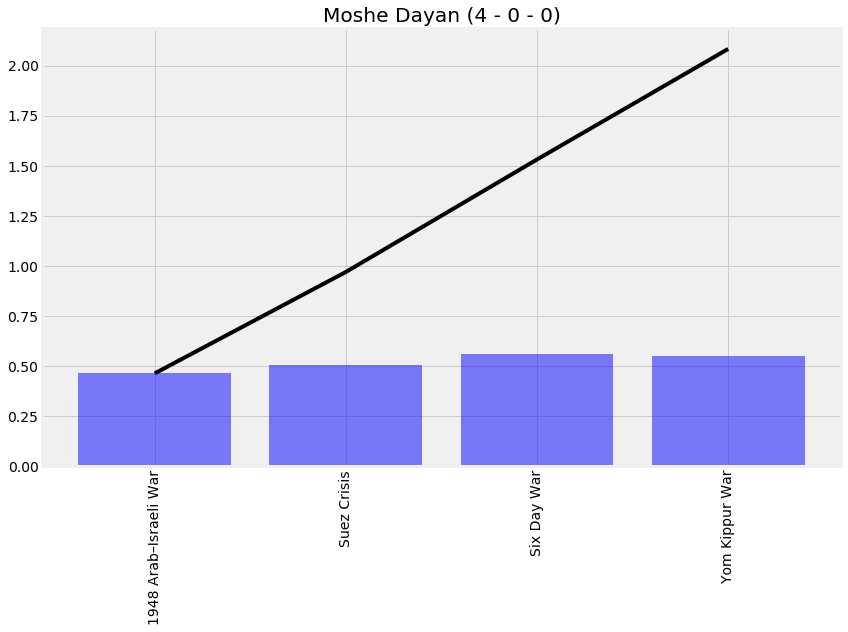

In [121]:
battle_list = []
graph('Moshe Dayan')

In [122]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,1948 Arab–Israeli War,Moshe Dayan,V,0.463883,1948.0,0.463883
1,Suez Crisis,Moshe Dayan,V,0.506449,1956.0,0.970332
2,Six Day War,Moshe Dayan,V,0.561764,1967.0,1.532096
3,Yom Kippur War,Moshe Dayan,V,0.551930,1973.0,2.084026


In [123]:
df_model[df_model.Battle == 'Battle_of_Borodino'].transpose()

,920
Battle,Battle_of_Borodino
pos_x,L
VorD,V
Infantry_x,160000
Cavalry_x,0
Artillery_x,587
Ships_x,0
Airforce_x,0
Special_x,0
pos_y,R


In [124]:
df_model[df_model.Battle == 'Six Day War']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Ships_y,Airforce_y,Special_y,"(2346, Infantry_x)",infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff


In [125]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,1948 Arab–Israeli War,Moshe Dayan,V,0.463883,1948.0,0.463883
1,Suez Crisis,Moshe Dayan,V,0.506449,1956.0,0.970332
2,Six Day War,Moshe Dayan,V,0.561764,1967.0,1.532096
3,Yom Kippur War,Moshe Dayan,V,0.551930,1973.0,2.084026


In [126]:
df_war = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [127]:
df_war.head()

,Battles,General,WAR
0,43,Napoleon,16.654440
1,17,Julius Caesar,7.344188
2,18,"Arthur Wellesley, 1st Duke of Wellington",7.118284
3,18,Takeda Shingen,6.160867
4,14,Khalid ibn al-Walid,5.622395


In [128]:
df_totalwar = df_totalwar[df_totalwar.General != 'Capital punishment']
df_totalwar = df_totalwar[df_totalwar.General != 'Lieutenant general']

In [129]:
df_totalwar[df_totalwar.General == 'Erwin Rommel']

,Battles,General,WAR
6582,9,Erwin Rommel,-1.535807


In [130]:
import seaborn as sns

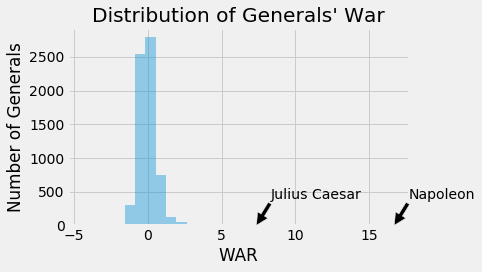

In [131]:
sns.distplot(df_totalwar['WAR'], kde = False, bins = 30)
plt.title("Distribution of Generals' War")
plt.ylabel('Number of Generals')
plt.annotate('Napoleon', xy = (16.713, 1), xytext = (17.713, 400), arrowprops = dict(facecolor = 'black'))
plt.annotate('Julius Caesar', xy = (7.364545, 1), xytext = (8.364545, 400), arrowprops = dict(facecolor = 'black'))
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/distplot.png')

In [132]:
def index():
    output_file('docs/index.html')
    source = ColumnDataSource(data = dict(battles = df_totalwar.Battles,
                                          war = df_totalwar.WAR,
                                          general = df_totalwar.General))

    hover = HoverTool(tooltips = [('General', '@general'),
                                  ('Battles', '@battles'),
                                  ('WAR', '@war'),
                                      ])
    p = figure(title = 'WAR vs Number of Battles',
               plot_height = 600, 
               plot_width = 800,

               tools = [hover, "tap", 'box_zoom', ResetTool()])
    p.circle(x = 'war', y = 'battles', size = 10, source = source)
    p.xaxis.axis_label = 'WAR'
    p.yaxis.axis_label = 'Battles'

    link = "{}.html".format('@general')

    if link == 'https://ethanarsht.github.io/military_rankings/Thomas de Courtenay, 5th/13th Earl of Devon':
            link = 'https://ethanarsht.github.io/military_rankings/Thomas de Courtenay'
    url = link
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)
    save(p)

In [133]:
index()

In [134]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,1948 Arab–Israeli War,Moshe Dayan,V,0.463883,1948.0,0.463883
1,Suez Crisis,Moshe Dayan,V,0.506449,1956.0,0.970332
2,Six Day War,Moshe Dayan,V,0.561764,1967.0,1.532096
3,Yom Kippur War,Moshe Dayan,V,0.551930,1973.0,2.084026


In [135]:
def bokeh(commander):
    global df_battles
    
    df_battles = pd.DataFrame()
    commander_war(commander)
    
#     df_battles = df_battles[df_battles.General == commander]
    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    if commander == 'Thomas de Courtenay, 5th/13th Earl of Devon':
        commander = 'Thomas de Courtenay'
    
    output_file('docs/{}.html'.format(commander))
#     output_file('{}.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover, "tap"])
#     p.xaxis.axis_label = "General's Biography: en.wikipedia.org/wiki/{}".format(commander)
    
    p.line(x = 'battle', y = 'cumulative', source = source, line_width = 5)
#     url = 'en.wikipedia.org/wiki/{}'.format(commander)
#     taptool = p.select(type=TapTool)
#     taptool.callback = OpenURL(url=url)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = 'battle', 
           top = 'value', 
           source = source, 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5)
    url = 'https://en.wikipedia.org/wiki/@battle'
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)
    
    p.xaxis.major_label_orientation = math.pi/2
    

#     show(p)
    save(p)

In [136]:
battle_list = []
bokeh('Takeda Shingen')

6.16086672559


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [ ]:

count = 0
for general in df_run.belligerent.unique()[1:]:
    battle_list = []
    count += 1
    print(str(count) + '/' + str(len(df_run.belligerent.unique())))
    print(general)
    bokeh(general)

In [ ]:
mka = df_run.loc[8965, 'belligerent']

In [ ]:
mka

In [ ]:
df_battles

In [ ]:
battle_list = []
bokeh(u'Ariel Sharon')

In [ ]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [ ]:
df_warchart = df_warchart.sort_values('Values', ascending = True)

In [ ]:
df_warchart

In [ ]:
df_warchart = df_warchart.iloc[::-1]

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('napoleon_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
df_warchart_two = pd.DataFrame({'Labels': ['Win = -1', 'Replacement-Level Performance = .49', 'WAR From Battle = -.51'],
              'Values': [-1, -.49, -.51]})

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart_two.index, df_warchart_two.Values, width = 1, color = ['red', 'blue', 'white'])
plt.xticks(df_warchart_two.index, df_warchart_two.Labels, rotation = 45)
plt.title("Kutuzov's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/kutuzov_war_sample')

# ax.set_axis_bgcolor('gray')